In [1]:
# Import

import numpy
import pandas
import torch
import yaml

import sys
sys.path.append('..')

from harmonica.util import mod, symplectic, is_symplectic
from harmonica.statistics import mean, variance
from harmonica.statistics import weighted_mean, weighted_variance
from harmonica.window import Window
from harmonica.data import Data
from harmonica.frequency import Frequency
from harmonica.filter import Filter
from harmonica.decomposition import Decomposition
from harmonica.model import Model
from harmonica.table import Table

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

True


In [2]:
# Set data type and device

dtype = torch.float64
device = 'cpu'

# Example-01: Model setup

In [3]:
# Model configuration is stored in a yaml format with data for each location (a point of interest)
# Uncouped model specified by twiss parameters has the following format

# DEFAULT CONFIGURATION FILE
# NOTE, HEAD AND TAIL VIRTUAL LOCATIONS SHOULD ALWAYS PRESENT

# LOCATION RECORD
# <NAME>: {TYPE:<TYPE>, FLAG:<FLAG>, JOIN:<JOIN>, RISE:<RISE>, TIME:<TIME>, BX:<BX>, AX:<AX>, FX:<FX>, SIGMA_BX:<SIGMA_BX>, SIGMA_AX:<SIGMA_AX>, SIGMA_FX:<SIGMA_FX>, BY:<BY>, AX:<AY>, FY:<FY>, SIGMA_BY:<SIGMA_BY>, SIGMA_AY:<SIGMA_AY>, SIGMA_FY:<SIGMA_FY>}
# <NAME>:
#   LOCATION NAME
#   HEAD & TAIL ARE SPECIAL VIRTUAL LOCATIONS
# <TYPE>:
#   LOCATION TYPE (VIRTUAL OR MONITOR)
#   MONITOR TYPE SHOULD BE USED FOR LOCATIONS WHERE TBT DATA IS AVALIBLE
#   OTHER LOCATIONS WHERE TBT DATA IS NOT AVALIBLE DIRECTRY SHOULD BE DEFINED AS VIRTUAL
#   FREQUENCY AND OTHER PARAMETERS INFERRED FROM TBT DATA ARE NOT COMPUTED FOR VIRTUAL LOCATIONS
#   IF BPM IS OFF, TYPE IS CHANGED TO VIRTUAL
#   IF BPM IS FLAGGED (E.G. ANOMALY OR SHYNCHRONIZATION ERROR), TYPE IS CHANGED TO VIRTUAL
# <FLAG>:
#   FLAG TO COMPUTE OPTICS (0 OR 1)
# <JOIN>:
#   FLAG TO USE IN MIXED DATA COMPUTAION
# <RISE>:
#   LOCATION RISE
#   STARTING TURN FOR MONITOR LOCATION
# <TIME>:
#   PHYSICAL LOCATION
#   NOTE, ORDERING IS CHECKED BY PHYSICAL LOCATION
# <BX>, <AX>, <FX>, <BY>, <AY>, <FY>
#   UNCOUPLED TWISS PARAMETERS
#   NOTE, PHASE ADVANCE IS DEFIEND FROM HEAD TO LOCATION
# <SIGMA_BX>, <SIGMA_AX>, <SIGMA_FX>, <SIGMA_BY>, <SIGMA_AY>, <SIGMA_FY>
#   MODEL TWISS ERROR AT THE LOCATION AND PHASE ADVANCE ERROR FROM GIVEN LOCATION TO THE NEXT ONE

In [4]:
# Set uncopled Model instance

model = Model(path='../config.yaml', model='uncoupled', dtype=dtype, device=device)
model.data_frame

,HEAD,STP2,IV4P,STP4,SRP1,SRP2,SRP3,SRP4,SRP5,SRP6,...,NRP4,NRP3,NRP2,NRP1,NTP4,IV4E,NTP2,NTP0,STP0,TAIL
TYPE,VIRTUAL,MONITOR,VIRTUAL,MONITOR,MONITOR,MONITOR,MONITOR,MONITOR,MONITOR,MONITOR,...,MONITOR,MONITOR,MONITOR,MONITOR,MONITOR,VIRTUAL,MONITOR,MONITOR,MONITOR,VIRTUAL
FLAG,0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0
JOIN,0,1,0,1,1,1,1,1,1,1,...,1,1,1,1,1,0,1,1,1,0
RISE,-1,8,-1,8,8,8,8,8,8,8,...,9,9,9,9,9,-1,9,9,9,-1
TIME,0.0,0.0,4.1535,6.667,10.190565,17.337624,24.484683,31.631742,38.778801,45.92586,...,314.367774,321.514833,328.661892,335.808951,339.332516,341.846016,345.999516,353.307016,358.767516,366.075016
BX,7.467461,7.467461,14.238343,3.121346,4.735711,4.560311,4.48402,4.755363,4.490419,4.552264,...,4.755363,4.48402,4.560311,4.735711,3.121346,14.238343,7.467461,15.068229,15.068229,7.467461
AX,-0.678322,-0.678322,1.955065,0.382216,-0.801359,-0.720007,-0.769987,-0.788485,-0.715242,-0.788853,...,0.788485,0.769987,0.720007,0.801359,-0.382216,-1.955065,0.678322,0.187567,-0.187567,-0.678322
FX,0.0,0.0,0.385863,0.837521,1.965122,3.064451,4.221361,5.333373,6.443944,7.601242,...,45.781099,46.893111,48.050022,49.14935,50.276951,50.72861,51.114472,52.191233,52.562058,53.638818
SIGMA_BX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SIGMA_AX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# Main attributes

# yaml file path
# model.path

# model type
# model.model

# model dictionary (yaml file as dictionary)
# model.dict

# model data frame (yaml file as data frame)
# model.data_frame

# model size (total number of locations)
# model.size

# model location names, two special locations ('HEAD' and 'TAIL') should always present
# model.name

# model location type ('MONITOR' or 'VIRTUAL')
# model.kind

# model flag
# model.flag

# model join flag, flag to use location in data mixing
# model.join

# model rise, first turn
# model.rise

# model time, location position
# model.time

# model length, total length, 'TAIL' position
# model.length

# monitor/virtual index, indices of monitor/virtual locations
# model.monitor_index
# model.virtual_index

# number of monitor/virtual locations, 'HEAD' and 'TAIL' included
# model.monitor_count
# model.virtual_count

# monitor/virtual locations names
# model.monitor_name
# model.virtual_name

# twiss parameters for uncoupled model (data type and device are defined on initialization)
# bx/ax/by/ay -- beta and alpha values at the location
# fx/fy -- phase advance from start to the location
# model.bx
# model.ax
# model.fx
# model.by
# model.ay
# model.fy

# twiss parameters (systematic) errors for uncoupled model
# sigma_bx/sigma_ax/sigma_by/sigma_ay -- beta and alpha errors at the location,
# sigma_fx/sigma_fy -- phase advance error from the location to the next one
# model.sigma_bx
# model.sigma_ax
# model.sigma_fx
# model.sigma_by
# model.sigma_ay
# model.sigma_fy

# total phase advance from 'HEAD' to 'TAIL'
# model.mux
# model.muy

# total phase advance error from 'HEAD' to 'TAIL'
# model.sigma_mux
# model.sigma_muy

# tune
# model.nux
# model.nuy

# tune error
# model.sigma_nux
# model.sigma_nuy

# phase advance and error from the location to the next one
# model.phase_x, model.sigma_x
# model.phase_y, model.sigma_y

# phase advance and error from the monitor location to the next monitor location
# model.monitor_phase_x, model.monitor_sigma_x
# model.monitor_phase_y, model.monitor_sigma_y

# attributes related to generation of combinations (computed if limit is not None on initialization, see other examples for details)
# model.limit -- range limit
# model.count -- (uncoupled) range limit endpoints [1, 6, 15, 28, 45, 66, 91, 120, ...]
# model.combo -- (uncoupled) index combinations [..., [..., [[i, j], [i, k]], ...], ...]
# model.index -- (uncoupled) index combimations mod number of locations
# model.fx_ij -- (uncoupled) x model advance i to j
# model.fx_ik -- (uncoupled) x model advance i to k
# model.sigma_fx_ij -- (uncoupled) x model advance error i to j
# model.sigma_fx_ik -- (uncoupled) x model advance error i to k

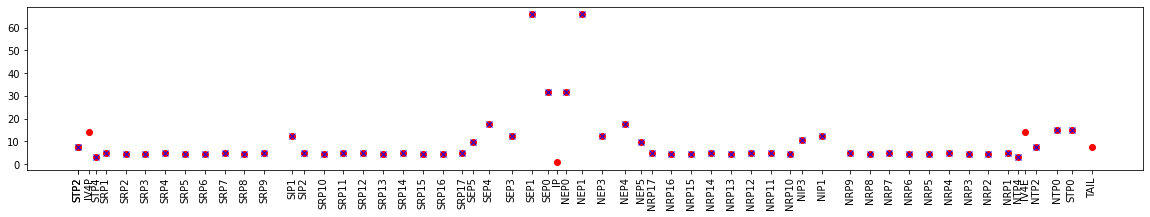

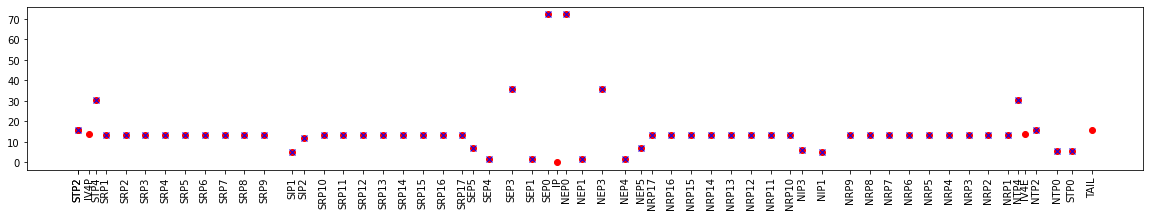

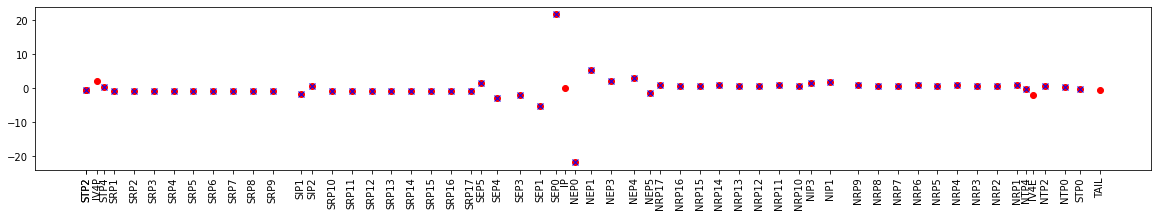

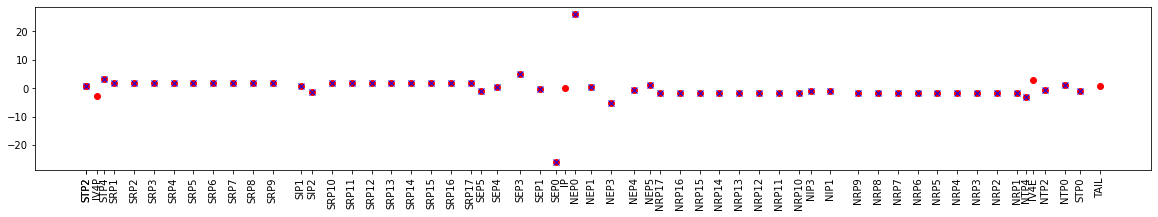

In [6]:
# Plot twiss beta & alpha

# Note, 'HEAD' and 'STP2' locations are at the same position

# bx
plt.figure(figsize=(20, 3))
plt.errorbar(model.time.cpu().numpy(), model.bx.cpu().numpy(), yerr=model.sigma_bx.cpu().numpy(), fmt=' ', color='red', marker='o')
plt.errorbar(model.time[model.monitor_index].cpu().numpy(), model.bx[model.monitor_index].cpu().numpy(), yerr=model.sigma_bx[model.monitor_index].cpu().numpy(), fmt=' ', color='blue', marker='x')
plt.xticks(model.time.cpu().numpy(), model.name)
locs, lbls = plt.xticks()
plt.setp(lbls, rotation=90)
plt.show()

# by
plt.figure(figsize=(20, 3))
plt.errorbar(model.time.cpu().numpy(), model.by.cpu().numpy(), yerr=model.sigma_by.cpu().numpy(), fmt=' ', color='red', marker='o')
plt.errorbar(model.time[model.monitor_index].cpu().numpy(), model.by[model.monitor_index].cpu().numpy(), yerr=model.sigma_by[model.monitor_index].cpu().numpy(), fmt=' ', color='blue', marker='x')
plt.xticks(model.time.cpu().numpy(), model.name)
locs, lbls = plt.xticks()
plt.setp(lbls, rotation=90)
plt.show()

# ax
plt.figure(figsize=(20, 3))
plt.errorbar(model.time.cpu().numpy(), model.ax.cpu().numpy(), yerr=model.sigma_ax.cpu().numpy(), fmt=' ', color='red', marker='o')
plt.errorbar(model.time[model.monitor_index].cpu().numpy(), model.ax[model.monitor_index].cpu().numpy(), yerr=model.sigma_ax[model.monitor_index].cpu().numpy(), fmt=' ', color='blue', marker='x')
plt.xticks(model.time.cpu().numpy(), model.name)
locs, lbls = plt.xticks()
plt.setp(lbls, rotation=90)
plt.show()

# ay
plt.figure(figsize=(20, 3))
plt.errorbar(model.time.cpu().numpy(), model.ay.cpu().numpy(), yerr=model.sigma_ay.cpu().numpy(), fmt=' ', color='red', marker='o')
plt.errorbar(model.time[model.monitor_index].cpu().numpy(), model.ay[model.monitor_index].cpu().numpy(), yerr=model.sigma_ay[model.monitor_index].cpu().numpy(), fmt=' ', color='blue', marker='x')
plt.xticks(model.time.cpu().numpy(), model.name)
locs, lbls = plt.xticks()
plt.setp(lbls, rotation=90)
plt.show()

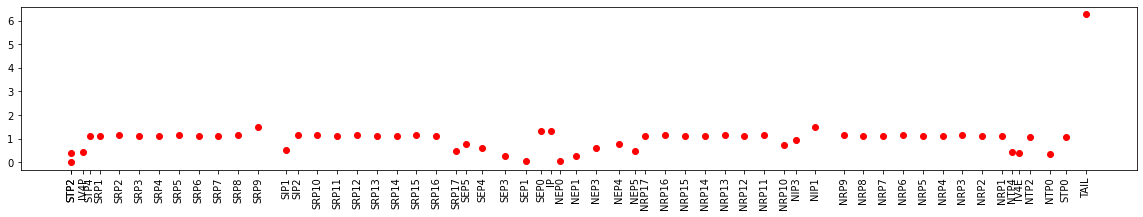

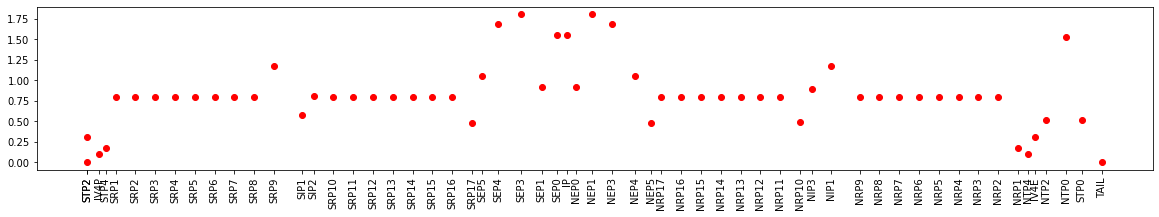

In [7]:
# Plot phase advance between locations

# phase_x
plt.figure(figsize=(20, 3))
plt.errorbar(model.time.cpu().numpy(), model.phase_x.cpu().numpy(), yerr=model.sigma_x.cpu().numpy(), fmt=' ', color='red', marker='o')
plt.xticks(model.time.cpu().numpy(), model.name)
locs, lbls = plt.xticks()
plt.setp(lbls, rotation=90)
plt.show()

# phase_y
plt.figure(figsize=(20, 3))
plt.errorbar(model.time.cpu().numpy(), model.phase_y.cpu().numpy(), yerr=model.sigma_y.cpu().numpy(), fmt=' ', color='red', marker='o')
plt.xticks(model.time.cpu().numpy(), model.name)
locs, lbls = plt.xticks()
plt.setp(lbls, rotation=90)
plt.show()

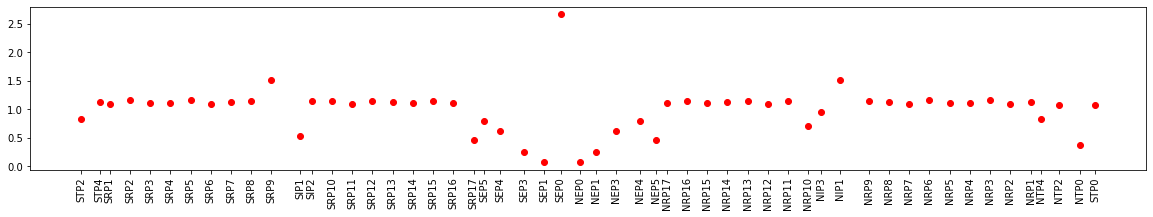

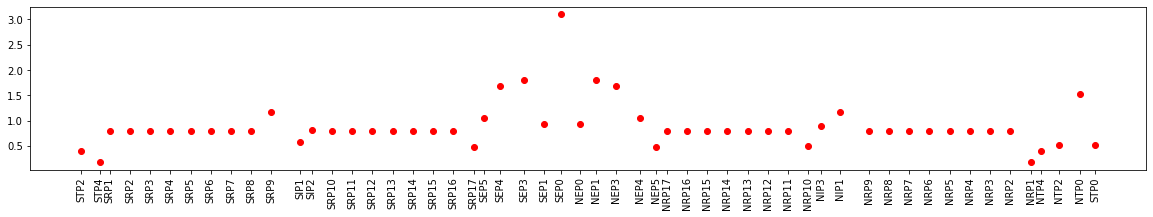

In [8]:
# Plot phase advance between monitor locations

# monitor_phase_x
plt.figure(figsize=(20, 3))
plt.errorbar(model.time[model.monitor_index].cpu().numpy(), model.monitor_phase_x.cpu().numpy(), yerr=model.monitor_sigma_x.cpu().numpy(), fmt=' ', color='red', marker='o')
plt.xticks(model.time[model.monitor_index].cpu().numpy(), model.monitor_name)
locs, lbls = plt.xticks()
plt.setp(lbls, rotation=90)
plt.show()

# monitor_phase_y
plt.figure(figsize=(20, 3))
plt.errorbar(model.time[model.monitor_index].cpu().numpy(), model.monitor_phase_y.cpu().numpy(), yerr=model.monitor_sigma_y.cpu().numpy(), fmt=' ', color='red', marker='o')
plt.xticks(model.time[model.monitor_index].cpu().numpy(), model.monitor_name)
locs, lbls = plt.xticks()
plt.setp(lbls, rotation=90)
plt.show()

# Example-02: Table & model setup

In [9]:
# Table class can be used as a container to store TbT parameters
# Frequency, amplitude and phase (including corresponding errors)

In [10]:
# Set uncoupled Model instance

model = Model(path='../config.yaml', model='uncoupled', dtype=dtype, device=device)
model.data_frame

,HEAD,STP2,IV4P,STP4,SRP1,SRP2,SRP3,SRP4,SRP5,SRP6,...,NRP4,NRP3,NRP2,NRP1,NTP4,IV4E,NTP2,NTP0,STP0,TAIL
TYPE,VIRTUAL,MONITOR,VIRTUAL,MONITOR,MONITOR,MONITOR,MONITOR,MONITOR,MONITOR,MONITOR,...,MONITOR,MONITOR,MONITOR,MONITOR,MONITOR,VIRTUAL,MONITOR,MONITOR,MONITOR,VIRTUAL
FLAG,0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0
JOIN,0,1,0,1,1,1,1,1,1,1,...,1,1,1,1,1,0,1,1,1,0
RISE,-1,8,-1,8,8,8,8,8,8,8,...,9,9,9,9,9,-1,9,9,9,-1
TIME,0.0,0.0,4.1535,6.667,10.190565,17.337624,24.484683,31.631742,38.778801,45.92586,...,314.367774,321.514833,328.661892,335.808951,339.332516,341.846016,345.999516,353.307016,358.767516,366.075016
BX,7.467461,7.467461,14.238343,3.121346,4.735711,4.560311,4.48402,4.755363,4.490419,4.552264,...,4.755363,4.48402,4.560311,4.735711,3.121346,14.238343,7.467461,15.068229,15.068229,7.467461
AX,-0.678322,-0.678322,1.955065,0.382216,-0.801359,-0.720007,-0.769987,-0.788485,-0.715242,-0.788853,...,0.788485,0.769987,0.720007,0.801359,-0.382216,-1.955065,0.678322,0.187567,-0.187567,-0.678322
FX,0.0,0.0,0.385863,0.837521,1.965122,3.064451,4.221361,5.333373,6.443944,7.601242,...,45.781099,46.893111,48.050022,49.14935,50.276951,50.72861,51.114472,52.191233,52.562058,53.638818
SIGMA_BX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SIGMA_AX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
# Load test data

data = pandas.read_pickle('../virtual_tbt.pkl.gz')

data_x = torch.tensor(data.X.to_list(), dtype=dtype, device=device)
data_y = torch.tensor(data.Y.to_list(), dtype=dtype, device=device)

# Set noise sigma for each BPM and plane

noise_x = 1.0E-6*(25.0 + 75.0*torch.rand(model.monitor_count, dtype=dtype, device=device))
noise_y = 1.0E-6*(25.0 + 75.0*torch.rand(model.monitor_count, dtype=dtype, device=device))

nux= 0.536883099, sigma_nux=1.72871682e-16
nux= 0.536883105, sigma_nux=1.08966494e-06, error=6.06471007e-09
nux= 0.536883071, sigma_nux=6.63852346e-07, error=2.79914518e-08


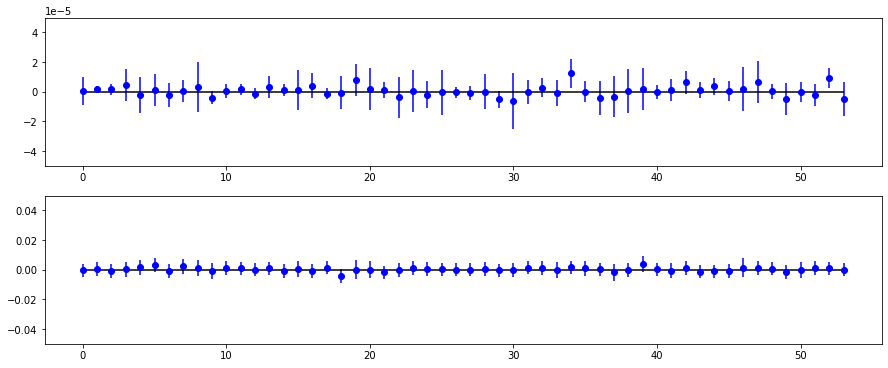

In [12]:
# Compute parameters for x plane

# Reference parameters
length = 4096
w = Window(length, 'cosine_window', 5.0, dtype=dtype, device=device)
d = Data.from_data(w, data_x[:, :length])
f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
frequency, spread = mean(f.frequency), variance(f.frequency).sqrt()
frequency = 1.0 - frequency
h = Decomposition(d)
result, _ = h.harmonic_sum(frequency, w.window, d.data)
_, _, ref_ax, ref_fx = result.T
print(f'nux={frequency.item():12.9}, sigma_nux={spread.item():12.9}')

# Frequency
length = 1024
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_data(w, data_x[:, :length])
d.add_noise(noise_x)
d.data.copy_(d.work)
l = Filter(d)
_, s = l.estimate_noise(limit=32)
f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
w = 1.0/s**2*torch.stack([spectrum[index] for index, spectrum in zip(f.ffrft_bin.to(torch.int64), f.ffrft_spectrum)])**2
nux, sigma_nux = weighted_mean(f.frequency), weighted_variance(f.frequency).sqrt()
nux = 1.0 - nux
print(f'nux={nux.item():12.9}, sigma_nux={sigma_nux.item():12.9}, error={abs(frequency-nux).item():12.9}')
nux, sigma_nux = weighted_mean(f.frequency, weight=w), weighted_variance(f.frequency, weight=w).sqrt()
nux = 1.0 - nux
print(f'nux={nux.item():12.9}, sigma_nux={sigma_nux.item():12.9}, error={abs(frequency-nux).item():12.9}')

# Amplitude
dec = Decomposition(d)
ax, sigma_ax, _ = dec.harmonic_amplitude(nux, length=128, order=1.0, sigma_frequency=sigma_nux, shift=True, count=64, step=8, method='noise')

# Phase
dec = Decomposition(d)
fx, sigma_fx, _ = dec.harmonic_phase(nux, length=256, order=0.0, sigma_frequency=sigma_nux, shift=True, count=256, step=8, method='noise')

plt.figure(figsize=(15, 3*2))
ax1 = plt.subplot(211)
ax1.errorbar(range(model.monitor_count), (ax - ref_ax).cpu().numpy(), yerr=sigma_ax.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, model.monitor_count - 1, colors='black')
ax1.set_ylim(-5.0E-5, +5.0E-5)
ax2 = plt.subplot(212)
ax2.errorbar(range(model.monitor_count), (fx - ref_fx).cpu().numpy(), yerr=sigma_fx.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, model.monitor_count - 1, colors='black')
ax2.set_ylim(-5.0E-2, +5.0E-2)
plt.show()

nux= 0.576774633, sigma_nux=1.82523846e-16
nux= 0.576774701, sigma_nux=1.45214488e-06, error=6.75055869e-08
nux= 0.576774692, sigma_nux=7.51031414e-07, error=5.82473449e-08


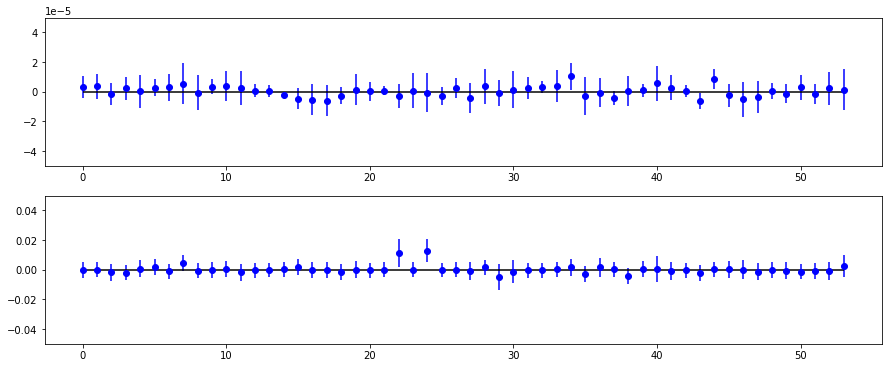

In [13]:
# Compute parameters for y plane

# Reference parameters
length = 4096
w = Window(length, 'cosine_window', 5.0, dtype=dtype, device=device)
d = Data.from_data(w, data_y[:, :length])
f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
frequency, spread = mean(f.frequency), variance(f.frequency).sqrt()
frequency = 1.0 - frequency
h = Decomposition(d)
result, _ = h.harmonic_sum(frequency, w.window, d.data)
_, _, ref_ay, ref_fy = result.T
print(f'nux={frequency.item():12.9}, sigma_nux={spread.item():12.9}')

# Frequency
length = 1024
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_data(w, data_y[:, :length])
d.add_noise(noise_y)
d.data.copy_(d.work)
l = Filter(d)
_, s = l.estimate_noise(limit=32)
f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
w = 1.0/s**2*torch.stack([spectrum[index] for index, spectrum in zip(f.ffrft_bin.to(torch.int64), f.ffrft_spectrum)])**2
nuy, sigma_nuy = weighted_mean(f.frequency), weighted_variance(f.frequency).sqrt()
nuy = 1.0 - nuy
print(f'nux={nuy.item():12.9}, sigma_nux={sigma_nuy.item():12.9}, error={abs(frequency - nuy).item():12.9}')
nuy, sigma_nuy = weighted_mean(f.frequency, weight=w), weighted_variance(f.frequency, weight=w).sqrt()
nuy = 1.0 - nuy
print(f'nux={nuy.item():12.9}, sigma_nux={sigma_nuy.item():12.9}, error={abs(frequency - nuy).item():12.9}')

# Amplitude
dec = Decomposition(d)
ay, sigma_ay, _ = dec.harmonic_amplitude(nuy, length=128, order=1.0, sigma_frequency=sigma_nuy, shift=True, count=64, step=8, method='noise')

# Phase
dec = Decomposition(d)
fy, sigma_fy, tmp = dec.harmonic_phase(nuy, length=256, order=0.0, sigma_frequency=sigma_nuy, shift=True, count=256, step=8, method='noise')

plt.figure(figsize=(15, 3*2))
ax1 = plt.subplot(211)
ax1.errorbar(range(model.monitor_count), (ay - ref_ay).cpu().numpy(), yerr=sigma_ay.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, model.monitor_count - 1, colors='black')
ax1.set_ylim(-5.0E-5, +5.0E-5)
ax2 = plt.subplot(212)
ax2.errorbar(range(model.monitor_count), (fy - ref_fy).cpu().numpy(), yerr=sigma_fy.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, model.monitor_count - 1, colors='black')
ax2.set_ylim(-5.0E-2, +5.0E-2)
plt.show()

In [14]:
# Set Table instance

table = Table(model.monitor_name, nux, nuy, ax, ay, fx, fy, sigma_nux, sigma_nuy, sigma_ax, sigma_ay, sigma_fx, sigma_fy, dtype=dtype, device=device)
table

Table(54)

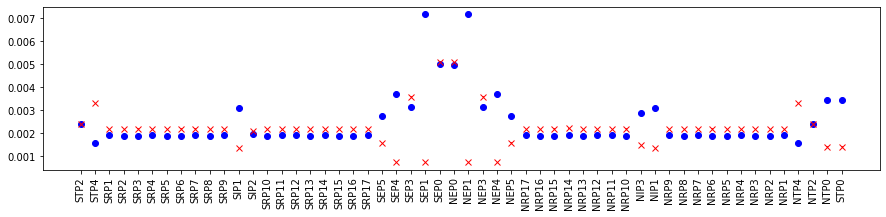

In [15]:
# Plot amplitudes

plt.figure(figsize=(15, 3))
plt.errorbar(range(table.size), table.ax.cpu().numpy(), yerr=table.sigma_ax.cpu().numpy(), fmt=' ', color='blue', marker='o')
plt.errorbar(range(table.size), table.ay.cpu().numpy(), yerr=table.sigma_ay.cpu().numpy(), fmt=' ', color='red', marker='x')
plt.xticks(range(table.size), table.name)
locs, labs = plt.xticks()
plt.setp(labs, rotation=90)
plt.show()

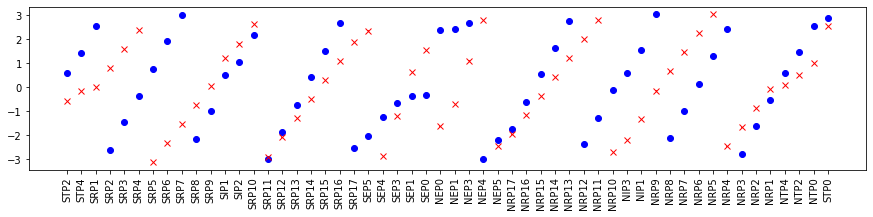

In [16]:
# Plot phases

plt.figure(figsize=(15, 3))
plt.errorbar(range(table.size), table.fx.cpu().numpy(), yerr=table.sigma_fx.cpu().numpy(), fmt=' ', color='blue', marker='o')
plt.errorbar(range(table.size), table.fy.cpu().numpy(), yerr=table.sigma_fy.cpu().numpy(), fmt=' ', color='red', marker='x')
plt.xticks(range(table.size), table.name)
locs, labs = plt.xticks()
plt.setp(labs, rotation=90)
plt.show()

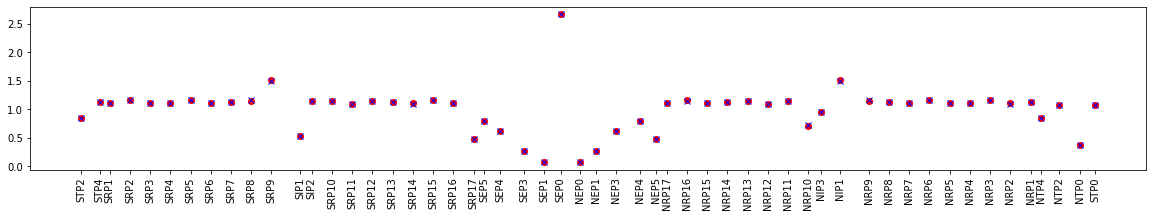

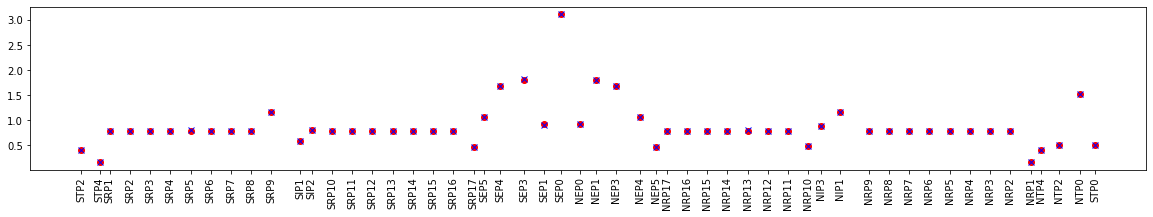

In [17]:
# Plot phase advance between monotors and compare with model

# Note, phase advance is mod two pi is both cases

# x
plt.figure(figsize=(20, 3))
plt.errorbar(model.time[model.monitor_index].cpu().numpy(), model.monitor_phase_x.cpu().numpy(), yerr=model.monitor_sigma_x.cpu().numpy(), fmt=' ', color='red', marker='o')
plt.errorbar(model.time[model.monitor_index].cpu().numpy(), table.phase_x.cpu().numpy(), yerr=table.sigma_x.cpu().numpy(), fmt=' ', color='blue', marker='x')
plt.xticks(model.time[model.monitor_index].cpu().numpy(), model.monitor_name)
locs, lbls = plt.xticks()
plt.setp(lbls, rotation=90)
plt.show()

# y
plt.figure(figsize=(20, 3))
plt.errorbar(model.time[model.monitor_index].cpu().numpy(), model.monitor_phase_y.cpu().numpy(), yerr=model.monitor_sigma_y.cpu().numpy(), fmt=' ', color='red', marker='o')
plt.errorbar(model.time[model.monitor_index].cpu().numpy(), table.phase_y.cpu().numpy(), yerr=table.sigma_y.cpu().numpy(), fmt=' ', color='blue', marker='x')
plt.xticks(model.time[model.monitor_index].cpu().numpy(), model.monitor_name)
locs, lbls = plt.xticks()
plt.setp(lbls, rotation=90)
plt.show()

# Example-03: Save/load uncoupled model

In [18]:
# Uncoupled model data can be saved using save_uncoupled method

m1 = Model(path='../config.yaml')
m1.save_uncoupled(file='model.json')

In [19]:
# Uncouple model data can be loaded into existing model

m2 = Model()
m2.load_uncoupled(file='model.json')
print(torch.allclose(m1.phase_x, m2.phase_x))
print(torch.allclose(m1.phase_y, m2.phase_y))

True
True


In [20]:
# Uncoupled model can be create from data

m3 = Model.from_uncoupled(file='model.json')
print(torch.allclose(m1.phase_x, m3.phase_x))
print(torch.allclose(m1.phase_y, m3.phase_y))

True
True


# Example-04: Generation of combination

In [21]:
# Range limit can be passed to (uncoupled) model on initialization
# This can be used to precompute data used for twiss parameters estimation from phase
# Once computed, model can be saved

In [22]:
# Set model instance

model = Model(path='../config.yaml', limit=8, error=True)
model.save_uncoupled()
del model

# limit -- maximum range limit
# error -- flag to compute model advance errors

# phase advance (and errors) are computed for all pairs combinations

In [23]:
# Load model with precomputed data

model = Model.from_uncoupled()
model

Model(path=../config.yaml, model=uncoupled)

In [24]:
# Maximum range limit

model.limit

8

In [25]:
# Range limit endpoints

model.count

# (0, 1)  -- limit=1
# (0, 6)  -- limit=2
# (0, 15) -- limit=3
# (0, 28) -- limit=4
# ...

tensor([  1,   6,  15,  28,  45,  66,  91, 120])

In [26]:
# Combinations

# combo -- index
# index -- index mod total number of locations

probe = 28
combo = model.combo[probe]
index = model.index[probe]

# upto limit=1
print(combo[0:1].cpu().tolist())
print(index[0:1].cpu().tolist())
print()

# upto limit=2
print(combo[0:6].cpu().tolist())
print(index[0:6].cpu().tolist())
print()

# only limit=2
print(combo[1:6].cpu().tolist())
print(index[1:6].cpu().tolist())
print()

[[[28, 27], [28, 29]]]
[[[28, 27], [28, 29]]]

[[[28, 27], [28, 29]], [[28, 26], [28, 27]], [[28, 26], [28, 29]], [[28, 26], [28, 30]], [[28, 29], [28, 30]], [[28, 27], [28, 30]]]
[[[28, 27], [28, 29]], [[28, 26], [28, 27]], [[28, 26], [28, 29]], [[28, 26], [28, 30]], [[28, 29], [28, 30]], [[28, 27], [28, 30]]]

[[[28, 26], [28, 27]], [[28, 26], [28, 29]], [[28, 26], [28, 30]], [[28, 29], [28, 30]], [[28, 27], [28, 30]]]
[[[28, 26], [28, 27]], [[28, 26], [28, 29]], [[28, 26], [28, 30]], [[28, 29], [28, 30]], [[28, 27], [28, 30]]]



In [27]:
# Phase advance and phase advance error (value for each combination for all locations)
# [[i, j], [i, k]]

print(model.fx_ij.shape)
print(model.fx_ik.shape)
print(model.sigma_fx_ij.shape)
print(model.sigma_fx_ik.shape)

torch.Size([120, 59])
torch.Size([120, 59])
torch.Size([120, 59])
torch.Size([120, 59])


In [28]:
# Compare with direct computation

probe = 28
value = 0
combo = model.combo[probe, value]
index = model.index[probe, value]

print(combo.cpu().tolist())
print(index.cpu().tolist())

phase, _ = Decomposition.phase_advance(*combo.T, model.nux, model.fx)
print(phase.cpu().tolist())

print([model.fx_ij[value, probe].cpu().item(), model.fx_ik[value, probe].cpu().item()])

[[28, 27], [28, 29]]
[[28, 27], [28, 29]]
[-1.3339903615135995, 1.33399036151393]
[-1.3339903615135995, 1.33399036151393]


# Example-05: Uncoupled twiss parameters

In [29]:
# In this example twiss parameters are computed for uncoupled model
# Uncoupled model is generated from twiss data

In [30]:
# Load uncoupled model

model = Model(path='../config.yaml', model='uncoupled', dtype=dtype, device=device)

In [31]:
# Generate one-turn matrix at the 'HEAD' location

matrix = model.matrix('HEAD', 'HEAD')
print(matrix)
print(is_symplectic(matrix))

tensor([[-8.174741941785e-01, -1.715086192481e+00, 0.000000000000e+00, 0.000000000000e+00],
        [4.490851430614e-02, -1.129060750494e+00, 0.000000000000e+00, 0.000000000000e+00],
        [0.000000000000e+00, 0.000000000000e+00, -1.189482037211e+00, -7.354804784961e+00],
        [0.000000000000e+00, 0.000000000000e+00, 4.179161971876e-02, -5.822961370188e-01]],
       dtype=torch.float64)
True


In [32]:
# Wolski twiss parameters for given input matrix can be computed with twiss staticmethod
# This method returns tuple of tunes, normalization matrix and Wolski twiss matrices for each plane
# Note, input matrix can have arbitrary even dimension

tunes, normal, wolski = model.twiss(matrix)

In [33]:
# Compare tunes with model tunes
# Note, only fractional part can be computed from the one-turn matrix

print(torch.stack([model.nux, model.nuy]))
print(tunes)

tensor([8.536883098737e+00, 7.576774633326e+00], dtype=torch.float64)
tensor([5.368830987374e-01, 5.767746333258e-01], dtype=torch.float64)


In [34]:
# Check normalization matrix

# Standard gauge is used to condition normalization matrix
# M = N R N^-1, R -- rotation matrix
# N[0, 0] > 0, N[2, 2] > 0, ...
# N[0, 1] = N[2, 3] = ... = 0

print(normal)

mux, muy = 2.0*numpy.pi*tunes
rotation = torch.tensor([
    [mux.cos(), +mux.sin(), 0, 0],
    [-mux.sin(), mux.cos(), 0, 0],
    [0, 0, muy.cos(), +muy.sin()],
    [0, 0, -muy.sin(), muy.cos()]
])

print(torch.allclose(matrix, normal @ rotation @ normal.inverse()))

tensor([[2.732665537666e+00, 0.000000000000e+00, 0.000000000000e+00, 0.000000000000e+00],
        [2.482271293933e-01, 3.659430640949e-01, 0.000000000000e+00, 0.000000000000e+00],
        [0.000000000000e+00, 0.000000000000e+00, 3.981756917048e+00, 0.000000000000e+00],
        [0.000000000000e+00, 0.000000000000e+00, -1.643596756619e-01, 2.511454166673e-01]],
       dtype=torch.float64)
True


In [35]:
# Check Wolski twiss matrices

print(wolski)

wx, wy = wolski
s = symplectic(2)

print(torch.allclose(matrix, wx @ s * mux.sin() - (wx @ s) @ (wx @ s) * mux.cos() + wy @ s * muy.sin() - (wy @ s) @ (wy @ s) * muy.cos()))

tensor([[[7.467460940747e+00, 6.783217220068e-01, 0.000000000000e+00, 0.000000000000e+00],
         [6.783217220068e-01, 1.955310339260e-01, 0.000000000000e+00, 0.000000000000e+00],
         [0.000000000000e+00, 0.000000000000e+00, 0.000000000000e+00, 0.000000000000e+00],
         [0.000000000000e+00, 0.000000000000e+00, 0.000000000000e+00, 0.000000000000e+00]],

        [[0.000000000000e+00, 0.000000000000e+00, 0.000000000000e+00, 0.000000000000e+00],
         [0.000000000000e+00, 0.000000000000e+00, 0.000000000000e+00, 0.000000000000e+00],
         [0.000000000000e+00, 0.000000000000e+00, 1.585438814646e+01, -6.544402754504e-01],
         [0.000000000000e+00, 0.000000000000e+00, -6.544402754504e-01, 9.008812329666e-02]]],
       dtype=torch.float64)
True


In [36]:
# Convert Wolski to CS and compare with model values

print(model.convert_wolski_cs(wolski))
print(torch.stack([model.ax[0], model.bx[0], model.ay[0], model.by[0]]))

tensor([-6.783217220068e-01, 7.467460940747e+00, 6.544402754504e-01, 1.585438814646e+01],
       dtype=torch.float64)
tensor([-6.783217220068e-01, 7.467460940747e+00, 6.544402754504e-01, 1.585438814646e+01],
       dtype=torch.float64)


In [37]:
# Wolski twiss matrices can be propagated using transport matrices between locations

# Define transport matrices from 'HEAD' to each location
# Note, the last matrix is 'HEAD' to 'TAIL'

transport = model.matrix(0*torch.arange(model.size - 1), 1 + torch.arange(model.size - 1))

# Propagate twiss

table = model.propagate_twiss(wolski, transport)
print(table.shape)

# Compare with model

[
    torch.allclose(model.convert_wolski_cs(w), torch.stack([model.ax[i + 1], model.bx[i + 1], model.ay[i + 1], model.by[i + 1]])) 
    for i, w in enumerate(table.swapaxes(0, 1))
].count(True)

torch.Size([2, 58, 4, 4])


58

In [38]:
# Phase advance between locations can be computed using advance_twiss
# For given normalization matrix at the first location and transport matrix between locations
# this function returns phase advance (mod two pi) and normalization matrix at the second location

advance, _ = model.advance_twiss(normal, model.matrix('STP2', 'STP4'))
print(advance)

print(torch.stack([model.fx[model.get_index('STP4')] - model.fx[model.get_index('STP2')], model.fy[model.get_index('STP4')] - model.fy[model.get_index('STP2')]]))

tensor([8.375209565894e-01, 4.070908562792e-01], dtype=torch.float64)
tensor([8.375209565894e-01, 4.070908562792e-01], dtype=torch.float64)


In [39]:
# Compute phase advance & normalization matrix between all adjacent locations and compare with model values

tunes, normal, wolski = model.twiss(matrix)

total = 0*tunes

for i in range(model.size):
    advance, normal = model.advance_twiss(normal, model.matrix(i, i + 1))
    total += advance
    j = int(mod(i + 1, model.size))
    ax, bx = model.ax[j], model.bx[j]
    ay, by = model.ay[j], model.by[j]
    nx = torch.tensor([[bx.sqrt(), 0], [-ax/bx.sqrt(), 1/bx.sqrt()]])
    ny = torch.tensor([[by.sqrt(), 0], [-ay/by.sqrt(), 1/by.sqrt()]])
    is_advance = torch.allclose(advance, mod(torch.stack([model.phase_x[i], model.phase_y[i]]), 2*numpy.pi, -numpy.pi))
    is_normal = torch.allclose(normal, torch.block_diag(nx, ny))
    print(f'{model.get_name(i):>6}{model.get_name(i + 1):>6} {is_advance} {is_normal}')
    
print(total)
print(torch.stack([model.mux, model.muy]))

  HEAD  STP2 True True
  STP2  IV4P True True
  IV4P  STP4 True True
  STP4  SRP1 True True
  SRP1  SRP2 True True
  SRP2  SRP3 True True
  SRP3  SRP4 True True
  SRP4  SRP5 True True
  SRP5  SRP6 True True
  SRP6  SRP7 True True
  SRP7  SRP8 True True
  SRP8  SRP9 True True
  SRP9  SIP1 True True
  SIP1  SIP2 True True
  SIP2 SRP10 True True
 SRP10 SRP11 True True
 SRP11 SRP12 True True
 SRP12 SRP13 True True
 SRP13 SRP14 True True
 SRP14 SRP15 True True
 SRP15 SRP16 True True
 SRP16 SRP17 True True
 SRP17  SEP5 True True
  SEP5  SEP4 True True
  SEP4  SEP3 True True
  SEP3  SEP1 True True
  SEP1  SEP0 True True
  SEP0    IP True True
    IP  NEP0 True True
  NEP0  NEP1 True True
  NEP1  NEP3 True True
  NEP3  NEP4 True True
  NEP4  NEP5 True True
  NEP5 NRP17 True True
 NRP17 NRP16 True True
 NRP16 NRP15 True True
 NRP15 NRP14 True True
 NRP14 NRP13 True True
 NRP13 NRP12 True True
 NRP12 NRP11 True True
 NRP11 NRP10 True True
 NRP10  NIP3 True True
  NIP3  NIP1 True True
  NIP1  NRP

In [40]:
# Since twiss method can handle arbitrary even dimension matrices
# One can construct a block matrix from one-turn matrices at all locations and compute corresponding twiss parameters

matrix = torch.block_diag(*model.matrix(torch.arange(model.size), torch.arange(model.size)))
print(matrix.shape)

_, _, table = model.twiss(matrix)
print(table.shape)

# Exctact beta values and compare with model
print(torch.allclose(model.bx, torch.stack([table[2*i + 0, 4*i + 0, 4*i + 0] for i in range(model.size)])))
print(torch.allclose(model.by, torch.stack([table[2*i + 1, 4*i + 2, 4*i + 2] for i in range(model.size)])))

torch.Size([236, 236])
torch.Size([118, 236, 236])
True
True


# Example-06: Coupled twiss parameters

In [41]:
# In this example twiss parameters are computed for coupled model
# A thin skew quadrupole is added to the one-turn matrix

In [42]:
# Load uncoupled model

model = Model(path='../config.yaml', model='uncoupled', dtype=dtype, device=device)

In [43]:
# Generate one-turn matrix at the 'HEAD' location

matrix = model.matrix('HEAD', 'HEAD')
print(matrix)
print(is_symplectic(matrix))

tensor([[-8.174741941785e-01, -1.715086192481e+00, 0.000000000000e+00, 0.000000000000e+00],
        [4.490851430614e-02, -1.129060750494e+00, 0.000000000000e+00, 0.000000000000e+00],
        [0.000000000000e+00, 0.000000000000e+00, -1.189482037211e+00, -7.354804784961e+00],
        [0.000000000000e+00, 0.000000000000e+00, 4.179161971876e-02, -5.822961370188e-01]],
       dtype=torch.float64)
True


In [44]:
# Generate thin skew quadrupole matrix

kick = model.matrix_kick(torch.tensor([0.0], dtype=dtype, device=device), torch.tensor([1.0E-3], dtype=dtype, device=device)).squeeze()
print(kick)
print(is_symplectic(kick))

tensor([[1.000000000000e+00, 0.000000000000e+00, 0.000000000000e+00, 0.000000000000e+00],
        [-0.000000000000e+00, 1.000000000000e+00, 1.000000000000e-03, 0.000000000000e+00],
        [0.000000000000e+00, 0.000000000000e+00, 1.000000000000e+00, 0.000000000000e+00],
        [1.000000000000e-03, 0.000000000000e+00, 0.000000000000e+00, 1.000000000000e+00]],
       dtype=torch.float64)
True


In [45]:
# Compute twiss

tunes, normal, wolski = model.twiss(kick @ matrix)
print(normal)
print(wolski)

tensor([[ 2.733011863453e+00,  3.346974230610e-16, -3.905040791675e-02,
         -3.197711738640e-17],
        [ 2.483160755541e-01,  3.657457500809e-01, -1.556901758468e-03,
         -1.056393628436e-02],
        [ 1.149739330129e-01, -2.319086872520e-16,  3.980640003650e+00,
          0.000000000000e+00],
        [-3.379408681657e-03,  3.587996081379e-03, -1.643330967144e-01,
          2.511122515631e-01]], dtype=torch.float64)
tensor([[[ 7.469353845777e+00,  6.786507803756e-01,  3.142251229120e-01,
          -9.235964018426e-03],
         [ 6.786507803756e-01,  1.954308270809e-01,  2.854987583677e-02,
           4.731328165488e-04],
         [ 3.142251229120e-01,  2.854987583677e-02,  1.321900527245e-02,
          -3.885439073879e-04],
         [-9.235964018426e-03,  4.731328165488e-04, -3.885439073879e-04,
           2.429411891765e-05]],

        [[ 1.524934358464e-03,  6.079764875449e-05, -1.554456159123e-01,
           6.417274460920e-03],
         [ 6.079764875449e-05,  1.14020

In [46]:
# Propagate twiss

transport = model.matrix(0*torch.arange(model.size - 1), 1 + torch.arange(model.size - 1))
transport[-1] = kick @ transport[-1]

table = model.propagate_twiss(wolski, transport).swapaxes(0, 1)
print(table.shape)
print(torch.allclose(wolski, table[-1]))

torch.Size([58, 2, 4, 4])
True


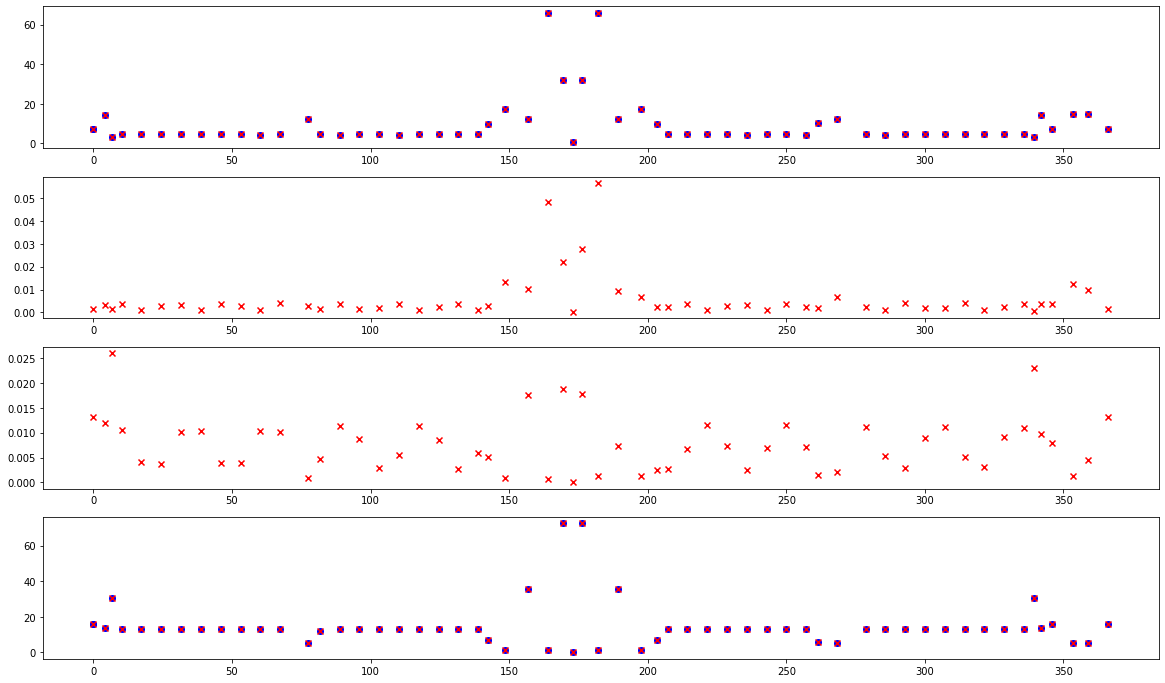

In [47]:
# Convert Wolski to Lebedev-Bogacz and plot beta values

bxx = torch.zeros(model.size - 1, dtype=dtype, device=device)
bxy = torch.zeros(model.size - 1, dtype=dtype, device=device)
byx = torch.zeros(model.size - 1, dtype=dtype, device=device)
byy = torch.zeros(model.size - 1, dtype=dtype, device=device)

for i in range(model.size - 1):
    _, bxx[i], _, bxy[i], _, byx[i], _, byy[i], *_ = model.convert_wolski_lb(table[i])

plt.figure(figsize=(20, 3*4))

ax1 = plt.subplot(411)
ax1.scatter(model.time.cpu().numpy(),  model.bx.cpu().numpy(), marker='o', color='blue')
ax1.scatter(model.time[1:].cpu().numpy(),  bxx.cpu().numpy(), marker='x', color='red')

ax2 = plt.subplot(412)
ax2.scatter(model.time[1:].cpu().numpy(),  bxy.cpu().numpy(), marker='x', color='red')

ax3 = plt.subplot(413)
ax3.scatter(model.time[1:].cpu().numpy(),  byx.cpu().numpy(), marker='x', color='red')

ax4 = plt.subplot(414)
ax4.scatter(model.time.cpu().numpy(),  model.by.cpu().numpy(), marker='o', color='blue')
ax4.scatter(model.time[1:].cpu().numpy(),  byy.cpu().numpy(), marker='x', color='red')

plt.show()

In [48]:
# Generate trajectories from uncoupled and coupled one-turn matrices

m1 = matrix
tunes1, normal1, wolski1 = model.twiss(m1)

m2 = kick @ matrix
tunes2, normal2, wolski2 = model.twiss(m2)

initial = torch.tensor([[1.0E-3, 0.0, 1.0E-3, 0.0], [2.0E-3, 0.0, 2.0E-3, 0.0], [3.0E-3, 0.0, 3.0E-3, 0.0], [4.0E-3, 0.0, 4.0E-3, 0.0], [5.0E-3, 0.0, 5.0E-3, 0.0]], dtype=dtype, device=device)

length = 4096

table1 = torch.zeros((length, 4, len(initial)), dtype=dtype, device=device)
table2 = torch.zeros((length, 4, len(initial)), dtype=dtype, device=device)

table1[0] = initial.T
table2[0] = initial.T

floquet1 = torch.zeros((length, 4, len(initial)), dtype=dtype, device=device)
floquet2 = torch.zeros((length, 4, len(initial)), dtype=dtype, device=device)
floquet3 = torch.zeros((length, 4, len(initial)), dtype=dtype, device=device)

floquet1[0] = torch.matmul(normal1.inverse(), table1[0])
floquet2[0] = torch.matmul(normal2.inverse(), table2[0])
floquet3[0] = torch.matmul(normal1.inverse(), table2[0])

for i in range(1, length):
    
    table1[i] = torch.matmul(m1, table1[i - 1])
    table2[i] = torch.matmul(m2, table2[i - 1])
    
    floquet1[i] = torch.matmul(normal1.inverse(), table1[i])
    floquet2[i] = torch.matmul(normal2.inverse(), table2[i])
    floquet3[i] = torch.matmul(normal1.inverse(), table2[i])
    
table1 = table1.swapaxes(0, -1)
table2 = table2.swapaxes(0, -1)

floquet1 = floquet1.swapaxes(0, -1)
floquet2 = floquet2.swapaxes(0, -1)
floquet3 = floquet3.swapaxes(0, -1)

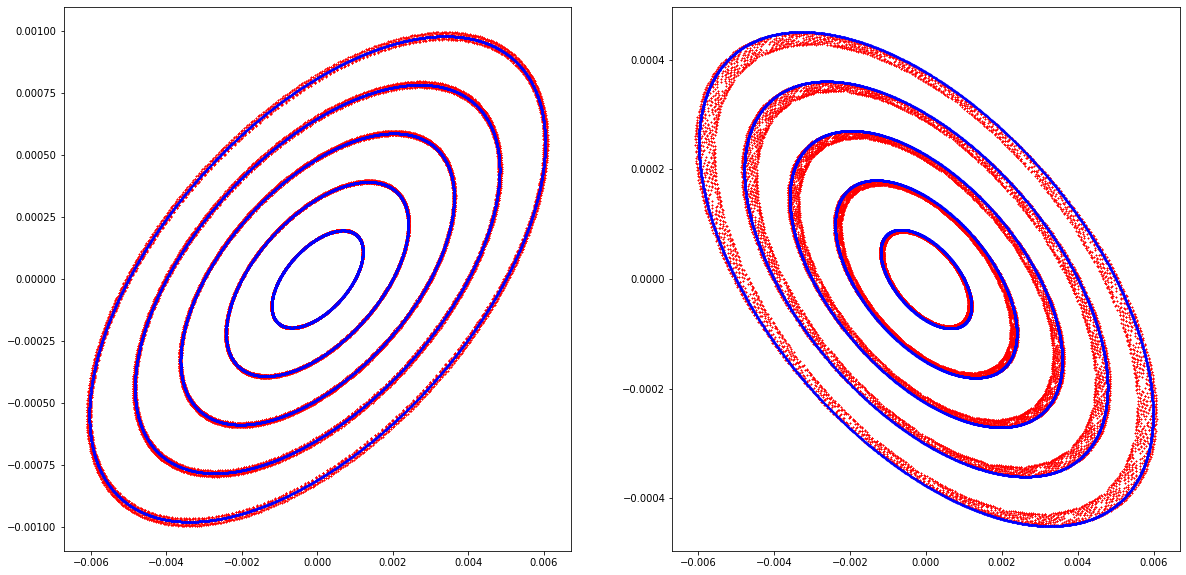

In [49]:
# Plot trajectories

plt.figure(figsize=(2*10, 10))

ax1 = plt.subplot(121)
for i in range(len(table1)):
    ax1.scatter(table2[i, 0], table2[i, 1], marker='x', s=1, color='red')
    ax1.scatter(table1[i, 0], table1[i, 1], marker='o', s=1, color='blue')

ax2 = plt.subplot(122)
for i in range(len(table1)):
    ax2.scatter(table2[i, 2], table2[i, 3], marker='x', s=1, color='red')
    ax2.scatter(table1[i, 2], table1[i, 3], marker='o', s=1, color='blue')

plt.show()

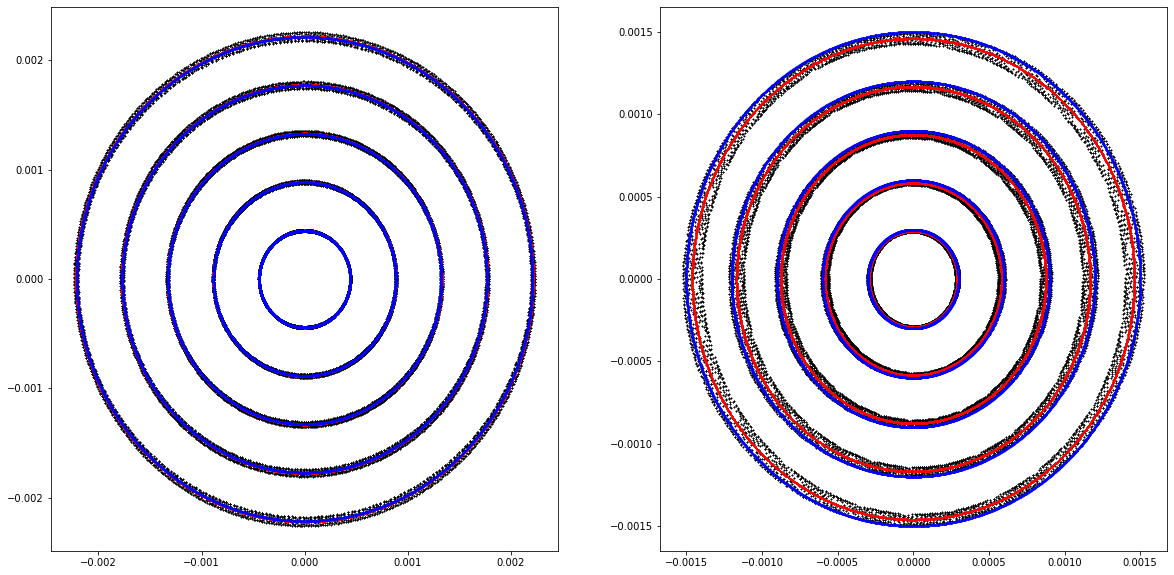

In [50]:
# Plot floquet trajectories
# Note, black points correspond to couped matrix with uncoupled normalization

plt.figure(figsize=(2*10, 10))

ax1 = plt.subplot(121)
for i in range(len(floquet1)):
    ax1.scatter(floquet3[i, 0], floquet3[i, 1], marker='x', s=1, color='black')
    ax1.scatter(floquet2[i, 0], floquet2[i, 1], marker='x', s=1, color='red')
    ax1.scatter(floquet1[i, 0], floquet1[i, 1], marker='o', s=1, color='blue')
    
ax2 = plt.subplot(122)
for i in range(len(floquet1)):
    ax2.scatter(floquet3[i, 2], floquet3[i, 3], marker='x', s=1, color='black')
    ax2.scatter(floquet2[i, 2], floquet2[i, 3], marker='x', s=1, color='red')
    ax2.scatter(floquet1[i, 2], floquet1[i, 3], marker='o', s=1, color='blue')
    
plt.show()

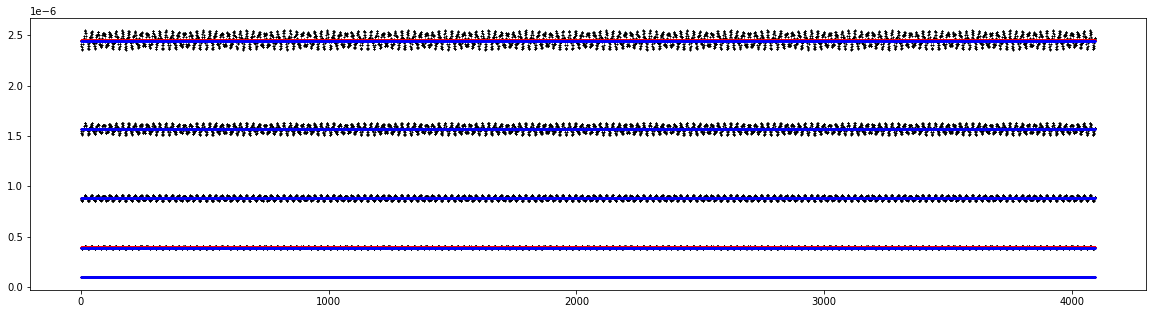

[5.120023590436883e-21, 2.0480094361747532e-20, 5.438481436350215e-20, 8.192037744699013e-20, 1.2406971903414186e-19]
[4.602534979376038e-21, 1.8410139917504152e-20, 4.3767867822112135e-20, 7.364055967001661e-20, 1.191306447103747e-19]
[2.1150693843072795e-09, 8.460277537229118e-09, 1.9035624458765497e-08, 3.384111014891647e-08, 5.2876734607682095e-08]


In [51]:
# Plot invariants for x plane
# Note, black points correspond to couped matrix with uncoupled normalization

invariant1 = 0.5*(floquet1[:, 0]**2 + floquet1[:, 1]**2)
invariant2 = 0.5*(floquet2[:, 0]**2 + floquet2[:, 1]**2)
invariant3 = 0.5*(floquet3[:, 0]**2 + floquet3[:, 1]**2)

plt.figure(figsize=(20, 5))

for i in range(len(invariant1)):
    plt.scatter(range(length), invariant3[i].cpu().numpy(), marker='x', s=1, color='black')
    plt.scatter(range(length), invariant2[i].cpu().numpy(), marker='x', s=1, color='red')
    plt.scatter(range(length), invariant1[i].cpu().numpy(), marker='o', s=1, color='blue')
    
plt.show()

# Compute spread
print(list(invariant1.std(-1).cpu().numpy()))
print(list(invariant2.std(-1).cpu().numpy()))
print(list(invariant3.std(-1).cpu().numpy()))

# Example-07: Wolski twiss parameters & model with errors

In [52]:
# Set uncoupled model

model = Model(path='../config.yaml', model='uncoupled', dtype=dtype, device=device)

In [53]:
# Twiss parameters are computed using transport matrices between locations
# Compute transport matrices

model.make_transport()
print(model.size)
print(model.transport.shape)

# Each transport matrix is a matrix from given location to the next one

print(model.transport[1])
print(model.matrix(1, 2))

59
torch.Size([59, 4, 4])
tensor([[9.267947966192e-01, 3.880769219803e+00, 0.000000000000e+00, 0.000000000000e+00],
        [-2.247045195013e-01, 1.380819331697e-01, 0.000000000000e+00, 0.000000000000e+00],
        [0.000000000000e+00, 0.000000000000e+00, 1.075036299054e+00, 4.432893586653e+00],
        [0.000000000000e+00, 0.000000000000e+00, 2.360867704534e-01, 1.903700863345e+00]],
       dtype=torch.float64)
tensor([[9.267947966192e-01, 3.880769219803e+00, 0.000000000000e+00, 0.000000000000e+00],
        [-2.247045195013e-01, 1.380819331697e-01, 0.000000000000e+00, 0.000000000000e+00],
        [0.000000000000e+00, 0.000000000000e+00, 1.075036299054e+00, 4.432893586653e+00],
        [0.000000000000e+00, 0.000000000000e+00, 2.360867704534e-01, 1.903700863345e+00]],
       dtype=torch.float64)


In [54]:
# Twiss parameters are computed from one-turn matrix at 'HEAD' location
# Parameters at other locations are computed then
# Compute one-turn matrix

model.make_turn()
print(model.turn)
print(model.matrix('HEAD', 'HEAD'))

tensor([[-8.174741941785e-01, -1.715086192481e+00, 0.000000000000e+00, 0.000000000000e+00],
        [4.490851430614e-02, -1.129060750494e+00, 0.000000000000e+00, 0.000000000000e+00],
        [0.000000000000e+00, 0.000000000000e+00, -1.189482037211e+00, -7.354804784961e+00],
        [0.000000000000e+00, 0.000000000000e+00, 4.179161971876e-02, -5.822961370188e-01]],
       dtype=torch.float64)
tensor([[-8.174741941785e-01, -1.715086192481e+00, 0.000000000000e+00, 0.000000000000e+00],
        [4.490851430614e-02, -1.129060750494e+00, 0.000000000000e+00, 0.000000000000e+00],
        [0.000000000000e+00, 0.000000000000e+00, -1.189482037211e+00, -7.354804784961e+00],
        [0.000000000000e+00, 0.000000000000e+00, 4.179161971876e-02, -5.822961370188e-01]],
       dtype=torch.float64)


In [55]:
# Compute twiss parameters at all locations
# Note, compute self.transport and/or self.turn are if not defined, errors are not applied
# Note, if flag is True, one-turn matrix is stable, else False and other parameters are not computed

flag = model.make_twiss()
print(flag)

print(model.tune)
print(torch.stack([model.nux, model.nuy]))

print(model.wolski.shape)
print(model.normal.shape)
print(model.advance.shape)

True
tensor([8.536883098737e+00, 7.576774633326e+00], dtype=torch.float64)
tensor([8.536883098737e+00, 7.576774633326e+00], dtype=torch.float64)
torch.Size([59, 2, 4, 4])
torch.Size([59, 4, 4])
torch.Size([59, 2])


In [56]:
# Compare computed twiss with model

# Twiss
print(all(torch.allclose(model.convert_wolski_cs(model.wolski[i]), torch.stack([model.ax[i], model.bx[i], model.ay[i], model.by[i]])) for i in range(model.size)))

# Normalization matrix
print(all(torch.allclose(model.normal[i], model.cs_normal(model.ax[i], model.bx[i], model.ay[i], model.by[i])) for i in range(model.size)))

# Transport normalization
print(all(torch.allclose(model.transport[i], model.normal[int(mod(i + 1, model.size))] @ model.matrix_rotation(model.advance[i]) @ model.normal[i].inverse()) for i in range(model.size)))

# Adjacent advance
print(torch.allclose(mod(torch.stack([model.phase_x, model.phase_y]), 2.0*numpy.pi, -numpy.pi), model.advance.T))

True
True
True
True


In [57]:
# Thin quadrupole errors and roll erros can be added to each transport matrix

# Compute initial transport matrices (without errors)

model.make_transport()

# Set thin quadrupole errors
# If float is passed, errors for each location are generated using input as sigma
# Errors are stored in self.kn and self.ks
# Generated matrices are stored in self.kick

model.make_kick(1.0E-4, 1.0E-4)
print(model.kick.shape)

# Set roll errors
# If float is passed, errors for each location are generated using input as sigma
# Errors are stored in self.angle
# Generated matrices are stored in self.roll

model.make_roll(1.0E-6)
print(model.roll.shape)

# Apply errors
# Note, transport matrices are modified
# self.transport[i] = self.roll[i] @ self.kick[i] @ self.transport[i]

model.apply_error()

# Generate one-turn matrix with errors
model.make_turn()

# Compute twiss for model with errors
# Change error values to make unstable

model.make_twiss()

torch.Size([59, 4, 4])
torch.Size([59, 4, 4])


True

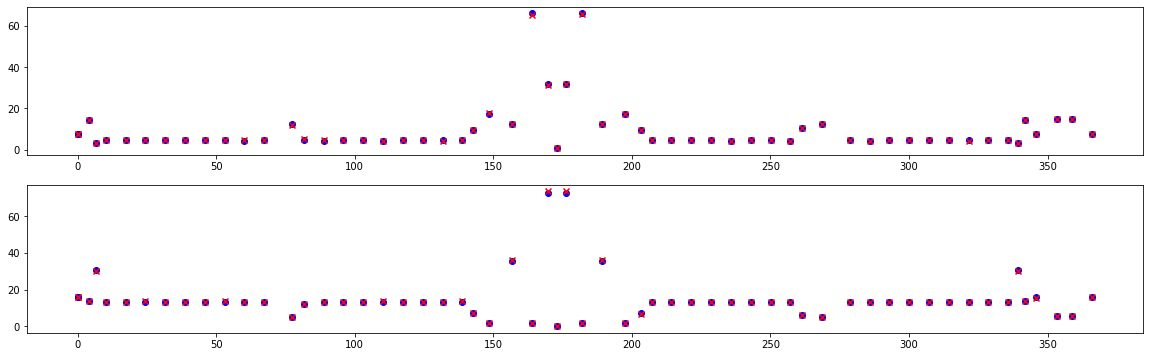

In [58]:
# Compare twiss

bx = torch.zeros(model.size, dtype=dtype, device=device)
by = torch.zeros(model.size, dtype=dtype, device=device)

for i in range(model.size):
    _, bx[i], _, _, _, _, _, by[i], *_ = model.convert_wolski_lb(model.wolski[i])
    
plt.figure(figsize=(20, 2*3))

ax1 = plt.subplot(211)
ax1.scatter(model.time.cpu().numpy(),  model.bx.cpu().numpy(), marker='o', color='blue')
ax1.scatter(model.time.cpu().numpy(),  bx.cpu().numpy(), marker='x', color='red')

ax2 = plt.subplot(212)
ax2.scatter(model.time.cpu().numpy(),  model.by.cpu().numpy(), marker='o', color='blue')
ax2.scatter(model.time.cpu().numpy(),  by.cpu().numpy(), marker='x', color='red')

plt.show()

In [59]:
# Minimum tune approach

S = symplectic(1)
M = model.turn
MUA, MUB = 2.0*numpy.pi*model.tune
A, B, C, D = M[0:2, 0:2], M[0:2, 2:4], M[2:4, 0:2], M[2:4, 2:4]
print(torch.allclose(M, torch.vstack([torch.hstack([A, B]), torch.hstack([C, D])])))
print(((C - S @ B.T @ S).abs().det().sqrt()/(numpy.pi*(MUA.sin() + MUB.sin()))).item())

True
-0.0007987315464877946


# Example-08: Generation of test trajectories

In [60]:
# Test trajectories at locations can be generated for given initial condition
# Trajectories are generated using transport matrices
# Errors can be applied to transport matrices

In [61]:
# Set uncoupled model

model = Model(path='../config.yaml', model='uncoupled', dtype=dtype, device=device)

# Compute transport matrices

model.make_transport()

# Generate and apply errors

model.make_kick(1.0E-3, 1.0E-3)
model.make_roll(1.0E-4)
model.apply_error()

# Compute one-turn matrix

model.make_turn()


# Compute twiss (not used in generation of trajectories)

flag = model.make_twiss()
print(flag)

# Set initial condition

initial = torch.tensor([0.002, 0.0, 0.002, 0.0], dtype=dtype, device=device)

# Set number of iterations

length = 2**12

# Generate trajectories

trajectory =  model.make_trajectory(length, initial)
print(trajectory.shape)

True
torch.Size([59, 4096, 4])


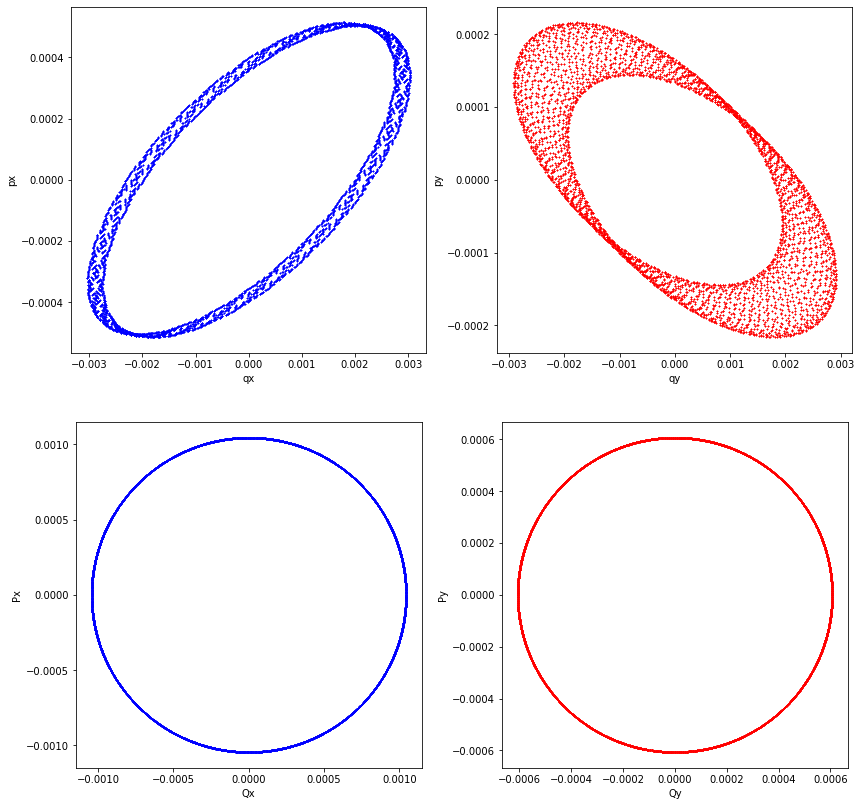

1.3284762489309891e-17
3.2209018684168944e-19


In [62]:
# Plot trajectory and floquet trajectory for given location index

index = 0

qx, px, qy, py = trajectory[index].T.cpu().numpy()
Qx, Px, Qy, Py = (model.normal[index].inverse() @ trajectory[index].T).cpu().numpy()

plt.figure(figsize=(2*7, 2*7))

# qx-px
ax1 = plt.subplot(221)
ax1.scatter(qx, px, marker='x', s=1, color='blue')
ax1.set_xlabel('qx')
ax1.set_ylabel('px')
ax1.set_aspect('auto')

# qy-py
ax2 = plt.subplot(2, 2, 2)
ax2.scatter(qy, py, marker='x', s=1, color='red')
ax2.set_xlabel('qy')
ax2.set_ylabel('py')
ax2.set_aspect('auto')

# Qx-Px
ax3 = plt.subplot(223)
ax3.scatter(Qx, Px, marker='x', s=1, color='blue')
ax3.set_xlabel('Qx')
ax3.set_ylabel('Px')
ax3.set_aspect('equal')

# Qy-Py
ax4 = plt.subplot(224)
ax4.scatter(Qy, Py, marker='x', s=1, color='red')
ax4.set_xlabel('Qy')
ax4.set_ylabel('Py')
ax4.set_aspect('equal')

plt.show()

# Conservation of invariants

print((Qx**2 + Px**2).std().item())
print((Qy**2 + Py**2).std().item())